In [1]:
import numpy as np
import pickle
from transformers import GPT2Tokenizer
import torch as torch
from scikitplot.decomposition import plot_pca_2d_projection, plot_pca_component_variance
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
path = "/om2/user/jackking/modular_transformers/scripts/dimensionality_reduction"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/om2/user/jackking/anaconda/envs/modular_transformers/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "azure-plant-15"
datatype = "natural_language"
sub_datatype = "fourgram_A"
model_type = "lm"

# model_name = "tough-water-16"
# datatype = "natural_language"
# sub_datatype = "bigram_A"
# model_type = "lm"

# model_name = "serene-flower-17"
# datatype = "natural_language"
# sub_datatype = "trigram_A"
# model_type = "lm"

# model_name = "chocolate-elevator-28"
# datatype = "cycle"
# sub_datatype = "B"
# model_type = "lm"

# model_name = "usual-disco-24"
# datatype = "toy"
# sub_datatype = "fourgram_A"
# model_type = "lm"

# model_name = "happy-sea-20"
# datatype = "cycle"
# sub_datatype = "A"
# model_type = "lm"

# model_name = "hardy-moon-27" #26
# datatype = "fragment"
# sub_datatype = "B"
# model_type = "lm"

# model_name = "sunny-feather-23"
# datatype = "toy"
# sub_datatype = "B"
# model_type = "lm"

# model_name = "sunny-feather-23"
# datatype = "natural_language"
# sub_datatype = "fourgram_B"
# model_type = "lm"

# model_name = "eager-dawn-33"
# datatype = "natural_language"
# sub_datatype = "natural"
# model_type = "lm"

model_name = "gpt2"
datatype = "natural_language"
sub_datatype = "natural"
model_type = "lm"

model_name = "gpt2-xl"
datatype = "natural_language_ud"
sub_datatype = "natural"
model_type = "lm"

In [3]:
def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

In [3]:
#num_labels, num_samples/num_labels, num_layers+1, context_len, embedding_dim
activations = pickle.load(open(f"{path}/activations/{datatype}/{sub_datatype}/{model_type}/{model_name}.pkl", "rb"))

In [157]:
data_path = f"{path}/data/{datatype}/valid_data_{sub_datatype}.pkl"
with open(data_path, "rb") as f:
    data = pickle.load(f)
data = data["inputs"]

In [17]:
#straightforward component analysis on the activations for a layer
def decompose(activations, layer):
    num_labels = activations.shape[0]
    num_samples = 50
    X = activations[:, :num_samples, layer, 1:, :]
    ctx_len = X.shape[-2]
    X = X.reshape(-1, activations.shape[-1])

    pca = PCA()
    pca.fit(X)
    plot_pca_component_variance(pca)

    # y = []
    # for i in range(X.shape[0] // ctx_len):
    #     y.append(np.arange(ctx_len))
    # y = np.array(y).reshape(-1)

    y = np.zeros(X.shape[0], dtype=int)
    samples_per_label = X.shape[0] // num_labels
    for label in range(num_labels):
        y[label*samples_per_label:(label+1)*samples_per_label] = label
    
    plot_pca_2d_projection(pca, X, y)

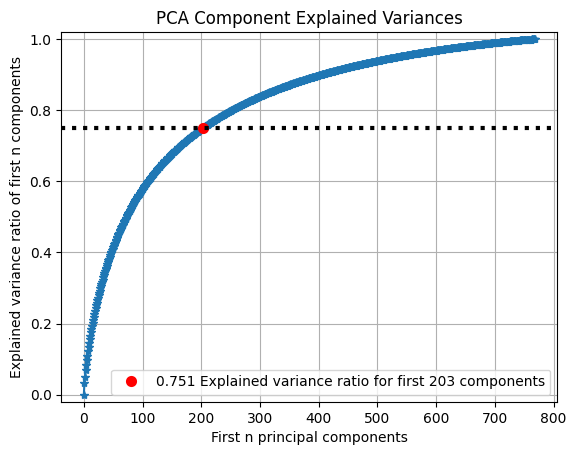

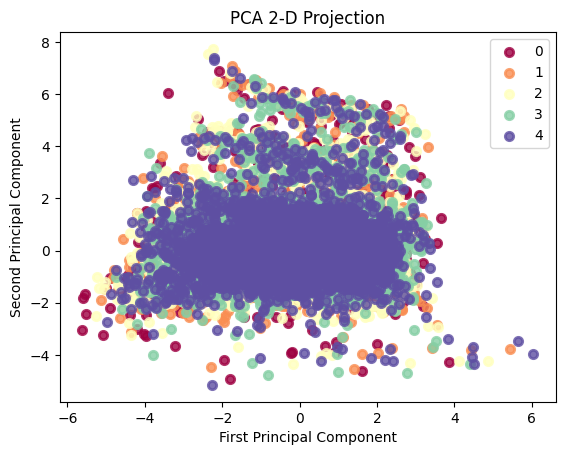

In [18]:
decompose(activations, 7)

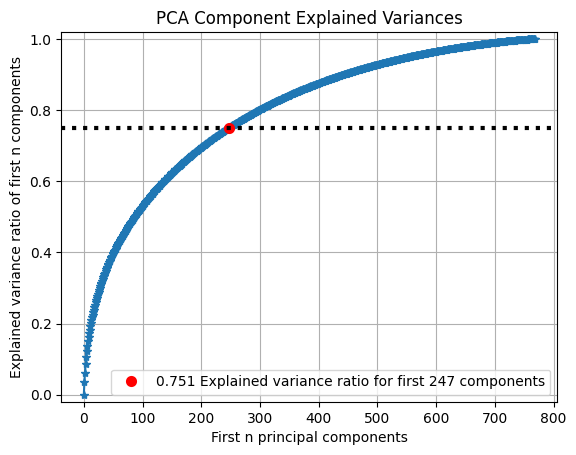

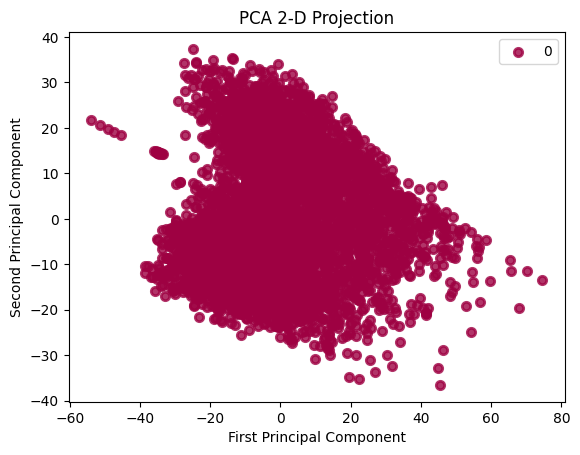

In [127]:
decompose(activations, 9)

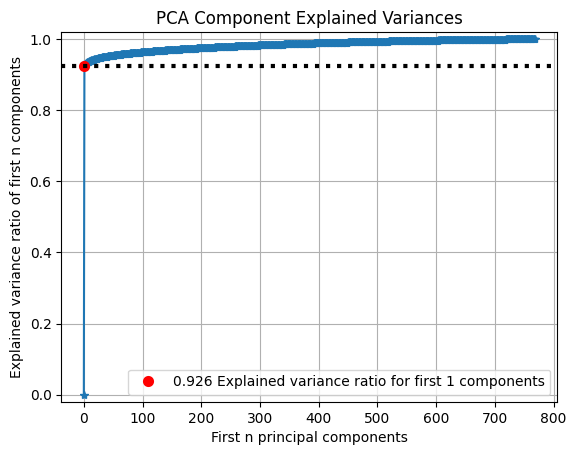

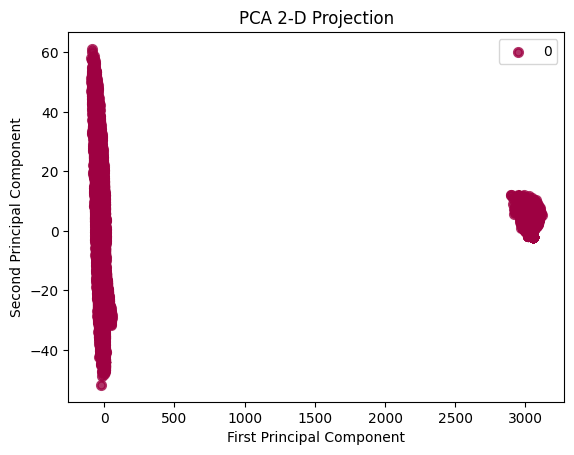

In [50]:
decompose(activations, 9)

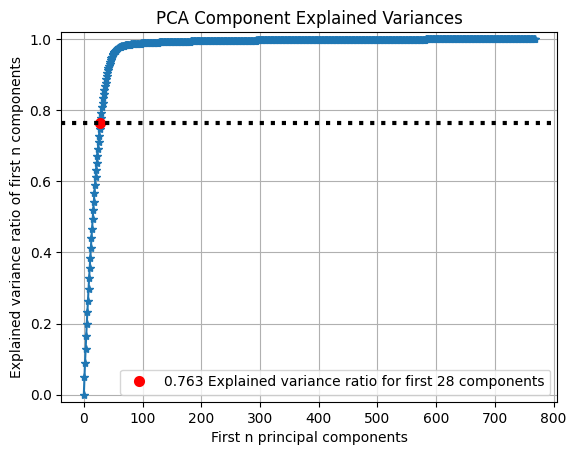

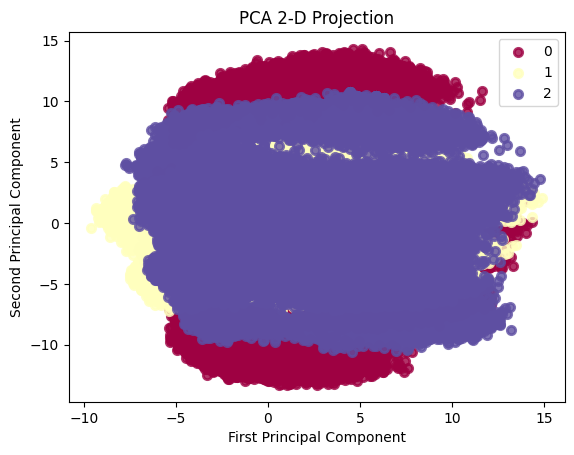

In [57]:
decompose(activations, 7)

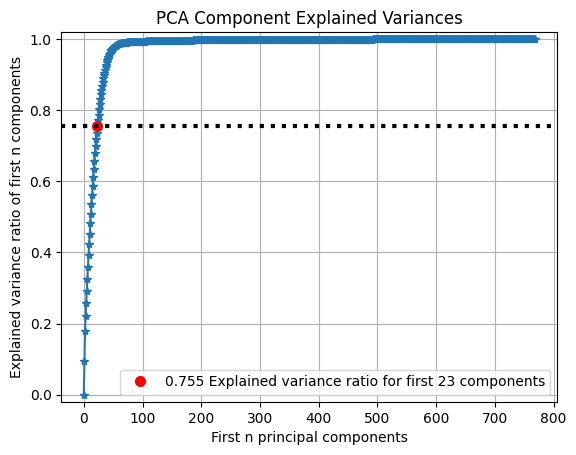

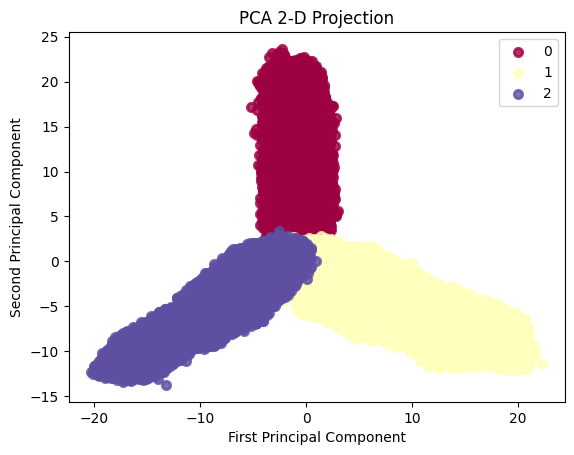

In [58]:
decompose(activations, 10)

In [19]:
#compare trajectories of one sample at different layers for one label

def compare_trajectories_by_layer(activations, layers, label, sample_idx):
    #just choose one sample
    combined_X = np.concatenate([activations[label, :, layer, 1:, :] for layer in layers], axis=0)
    combined_X = combined_X.reshape(-1, combined_X.shape[-1])
    pca = PCA(n_components=2)
    pca.fit(combined_X)

    for layer in layers:
        X = activations[label, :, layer, 1:, :]
        trajectory = X[sample_idx, :, :]
        trajectory = pca.transform(trajectory)

        plt.scatter(trajectory[:, 0], trajectory[:, 1], label=f"Layer {layer}")
        plt.plot(trajectory[:, 0], trajectory[:, 1], label=f"Layer {layer}")

    plt.legend()
    plt.show()

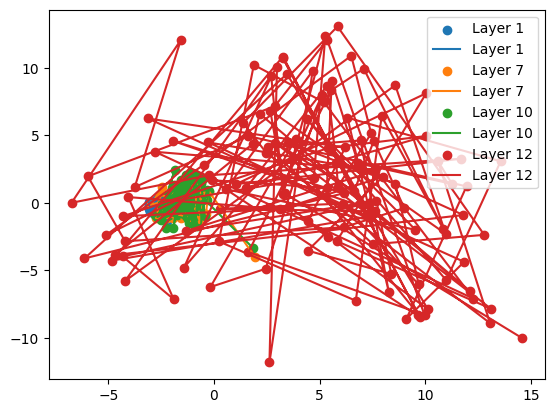

In [20]:
compare_trajectories_by_layer(activations, [1, 7, 10, 12], 0, 0)

In [50]:
#compare trajectories of different labels at one layer
#can do one or multiple samples

def compare_trajectories_by_label(activations, layer, label, sample_idxs):
    #just choose one sample
    X = activations[:, :, layer, :, :]
    X = X.reshape(-1, X.shape[-1])
    pca = PCA(n_components=2)
    pca.fit(X)

    color_dict = {0: "red", 1: "blue", 2: "green"}

    for label in [0, 1, 2]:
        X = activations[label, :, layer, :, :]

        trajectories = []
        for i in sample_idxs:
            trajectory = X[i, :, :]
            trajectory = pca.transform(trajectory)
            trajectories.append(trajectory)

            # plt.plot(trajectory[:, 0], trajectory[:, 1], color=color_dict[label])

        trajectories = np.array(trajectories)
        trajectory = np.mean(trajectories, axis=0)
        trajectory_std = np.std(trajectories, axis=0)
        trajectory_confidence = 1.96 * trajectory_std / np.sqrt(len(sample_idxs))

        plt.plot(trajectory[:, 0], trajectory[:, 1], color=color_dict[label])
        plt.fill_between(trajectory[:, 0], trajectory[:, 1] - trajectory_confidence[:, 1], trajectory[:, 1] + trajectory_confidence[:, 1], alpha=0.3, color=color_dict[label])

        plt.scatter(trajectory[0, 0], trajectory[0, 1], color=color_dict[label], label=f"Label {label}", s=100)

    plt.legend()
    plt.show()

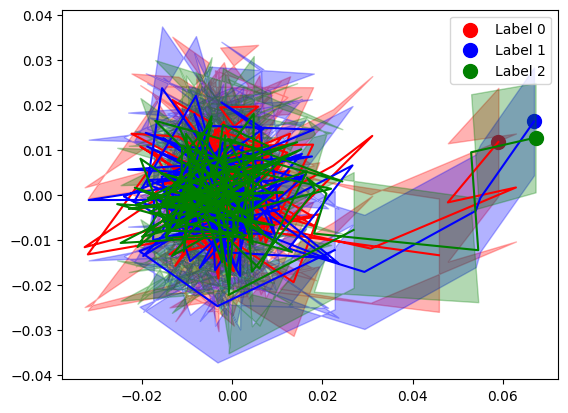

In [51]:
compare_trajectories_by_label(activations, 0, 1, np.arange(1000))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


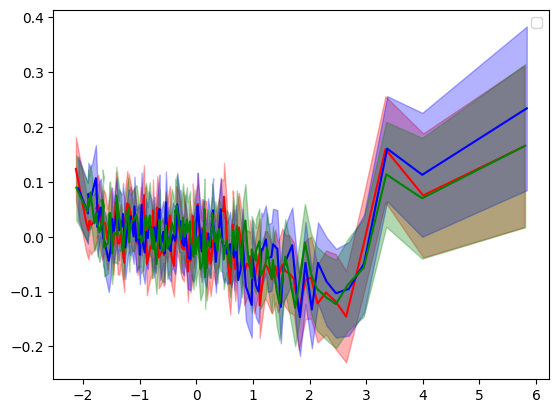

In [38]:
compare_trajectories_by_label(activations, 7, 1, np.arange(1000))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


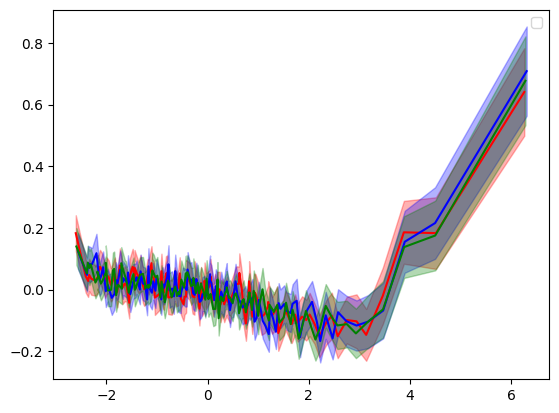

In [41]:
compare_trajectories_by_label(activations, 6, 1, np.arange(1000))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


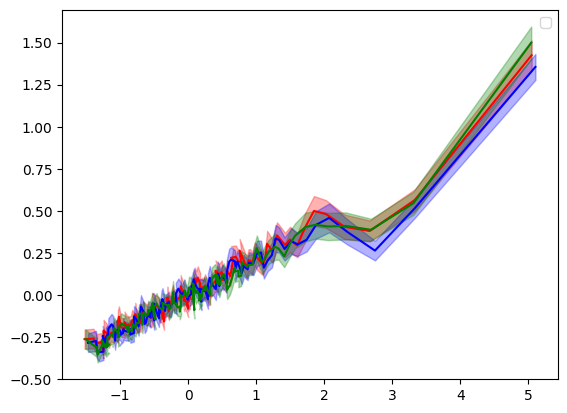

In [42]:
compare_trajectories_by_label(activations, 8, 1, np.arange(1000))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


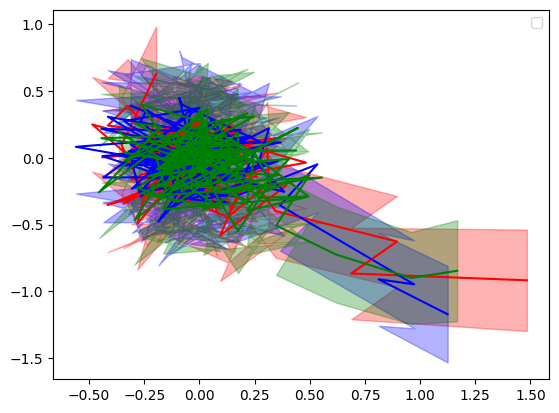

In [43]:
compare_trajectories_by_label(activations, 12, 1, np.arange(1000))

In [29]:
#do PCA on trajectories where trajectories are the difference between activations at two layers

def decompose_trajectories_over_layers(activations, layer):
    num_labels = activations.shape[0]
    differences = activations[:, :200, layer, 1:, :] - activations[:, :200, layer-1, 1:, :]
    ctx_len = differences.shape[-2]
    differences = differences.reshape(-1, differences.shape[-1])

    pca = PCA()
    pca.fit(differences)
    plot_pca_component_variance(pca)

    # y = []
    # for i in range(differences.shape[0] // ctx_len):
    #     y.append(np.arange(ctx_len))
    # y = np.array(y).reshape(-1)

    y = np.zeros(differences.shape[0], dtype=int)
    samples_per_label = differences.shape[0] // num_labels
    for label in range(num_labels):
        y[label*samples_per_label:(label+1)*samples_per_label] = label
    
    plot_pca_2d_projection(pca, differences, y)

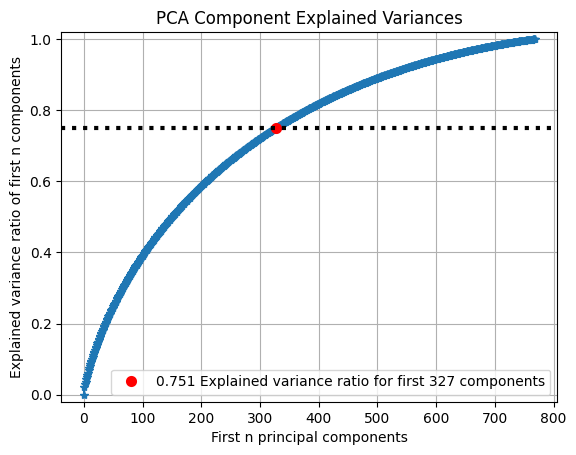

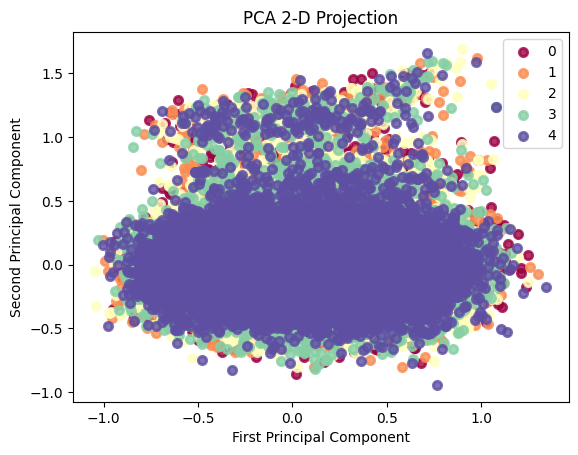

In [30]:
decompose_trajectories_over_layers(activations, 8)

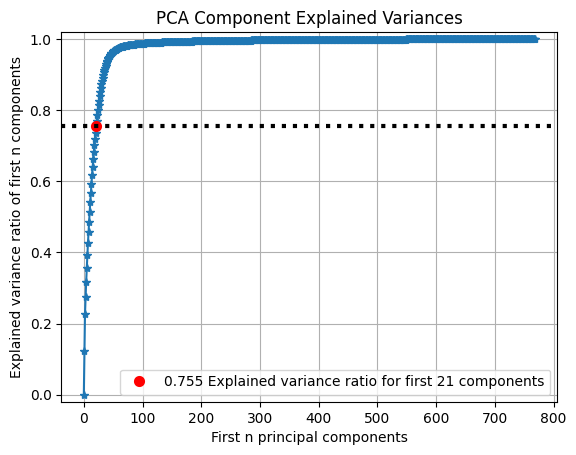

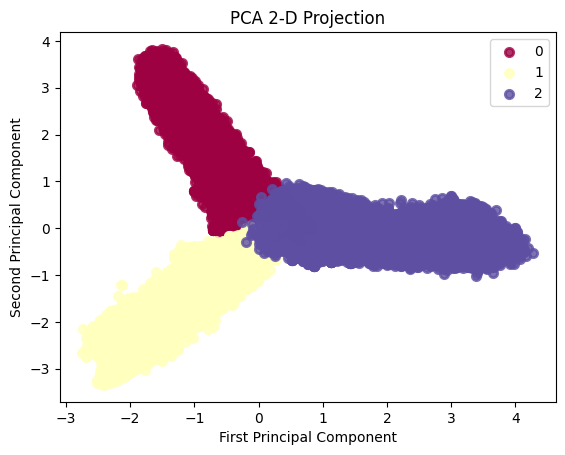

In [63]:
decompose_trajectories_over_layers(activations, 8)

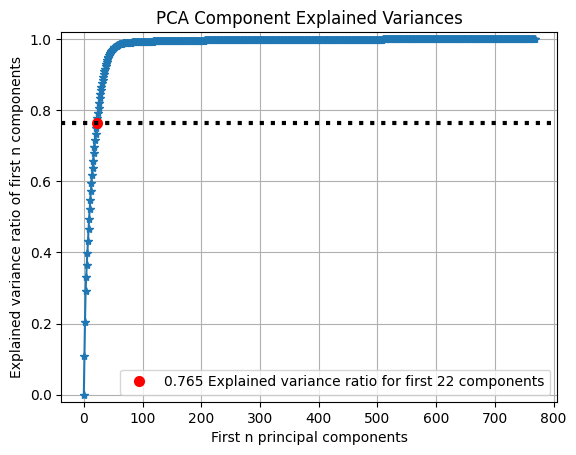

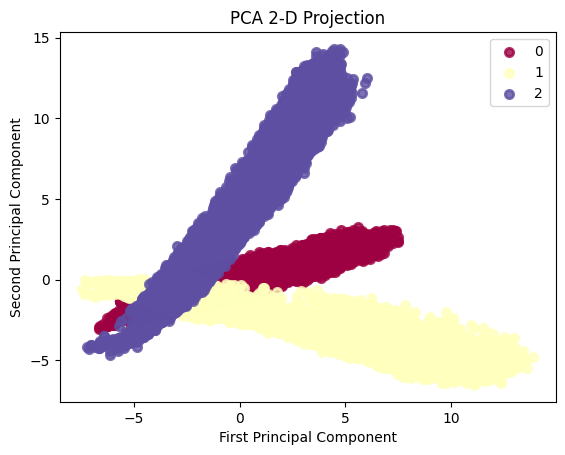

In [64]:
decompose_trajectories_over_layers(activations, 12)

In [39]:
# do PCA on trajectories where trajectories are the difference between adjacent token representation

def decompose_token_trajectories(activations, layer):
    num_labels = activations.shape[0]
    differences = activations[:, :200, layer, 2:, :] - activations[:, :200, layer, 1:-1, :]
    ctx_len = differences.shape[-2]
    differences = differences.reshape(-1, differences.shape[-1])

    pca = PCA()
    pca.fit(differences)
    plot_pca_component_variance(pca)

    # y = []
    # for i in range(differences.shape[0] // ctx_len):
    #     y.append(np.arange(ctx_len))
    # y = np.array(y).reshape(-1)

    y = np.zeros(differences.shape[0], dtype=int)
    samples_per_label = differences.shape[0] // num_labels
    for label in range(num_labels):
        y[label*samples_per_label:(label+1)*samples_per_label] = label
    
    plot_pca_2d_projection(pca, differences, y)

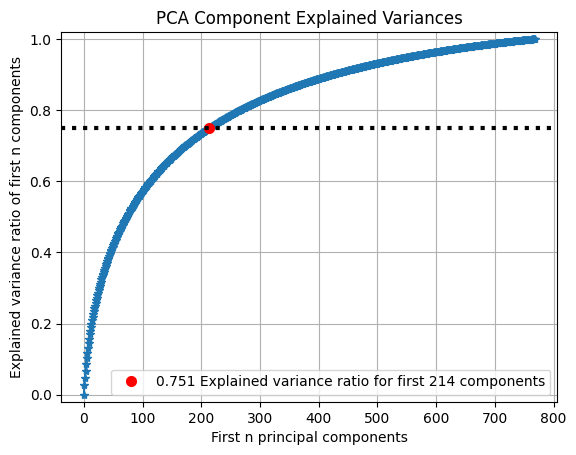

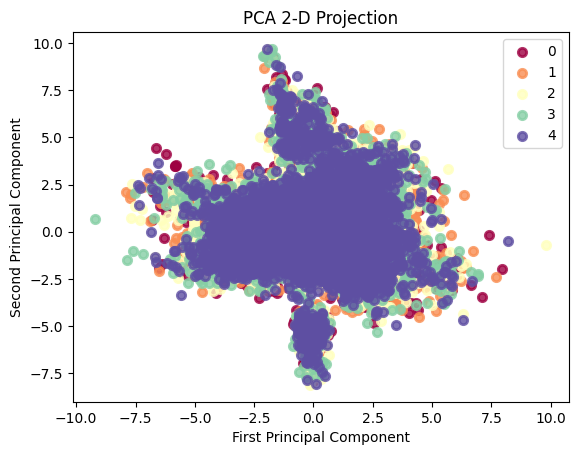

In [40]:
decompose_token_trajectories(activations, 7)

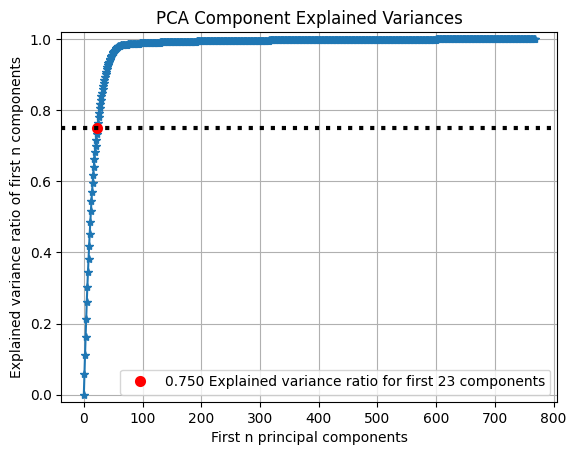

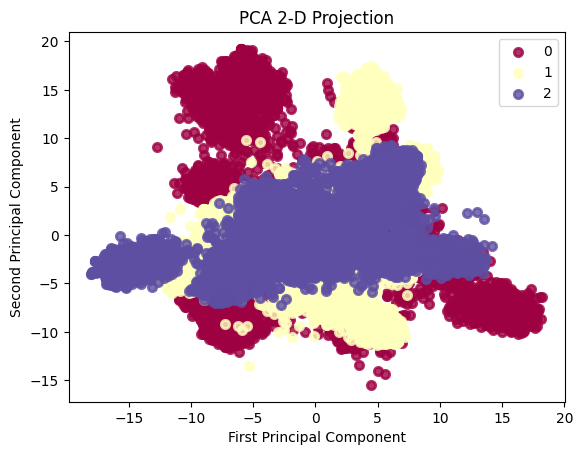

In [67]:
decompose_token_trajectories(activations, 7)

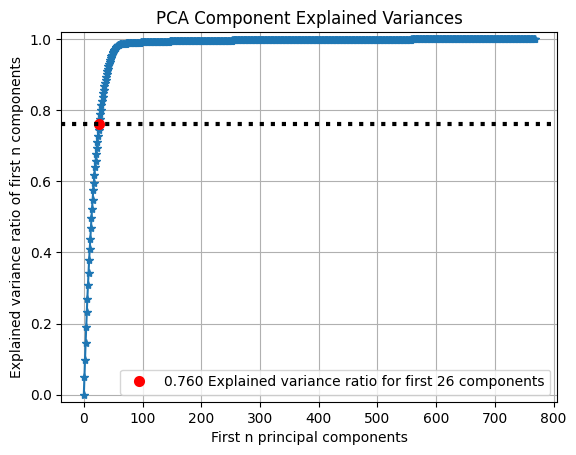

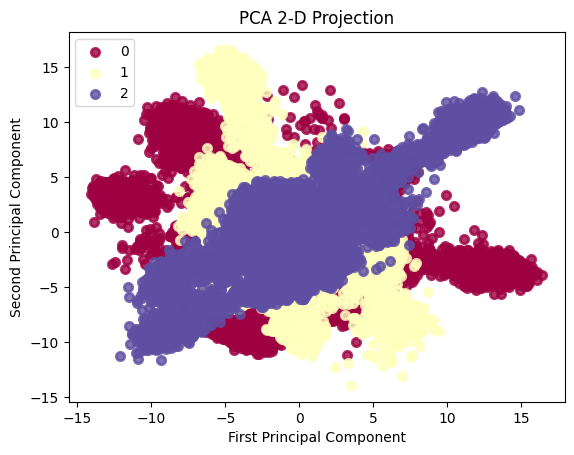

In [68]:
decompose_token_trajectories(activations, 12)

In [33]:
def predict_next_point_spline_batch(data, first_string_length):
    batch_size, context_length, embedding_dim = data.shape
    x = np.arange(context_length)
    
    # Initialize an array to store predictions
    predictions = np.zeros((batch_size, context_length-first_string_length, embedding_dim))
    
    for b in range(batch_size):
        for i in range(embedding_dim):
            for j in range(first_string_length, context_length):
                cs = CubicSpline(x[:j], data[b, :j, i])
                predictions[b, j-first_string_length, i] = cs(j)
    
    return predictions

In [34]:
def get_trajectories(activations, num_samples, first_string_length, layer):
    activations = activations[:, :num_samples, layer, :-10, :]
    print(activations.shape)
    activations = activations.reshape(-1, activations.shape[2], activations.shape[3])
    predictions = predict_next_point_spline_batch(activations, first_string_length)
    activations = activations[:, first_string_length:, :]
    trajectories = predictions.reshape(-1, predictions.shape[-1]) - activations.reshape(-1, activations.shape[-1])
    return trajectories

In [35]:
#do PCA on trajectories where trajectories are found by spline interpolation

def decompose_spline_trajectories(trajectories, num_samples, first_string_length, data=None):
    num_labels = activations.shape[0]

    # data = np.array(data)
    # data = data.reshape(num_labels, data.shape[0]//num_labels, data.shape[-1])
    # data = data[:, :num_samples, first_string_length:-10].flatten()
    # data = data.reshape(data.shape[-1], 1)
    # #remove all instances of padding
    # mask = np.all(data == tokenizer.eos_token_id, axis=1)
    # trajectories = trajectories[~mask, :]

    pca = PCA()
    pca.fit(trajectories)
    plot_pca_component_variance(pca)

    y = np.zeros(trajectories.shape[0], dtype=int)
    samples_per_label = trajectories.shape[0] // num_labels
    for label in range(num_labels):
        y[label*samples_per_label:(label+1)*samples_per_label] = label
    
    plot_pca_2d_projection(pca, trajectories, y)

In [36]:
num_samples = 5
first_string_length = 4
layer = 7
trajectories = get_trajectories(activations, num_samples, first_string_length, layer)

(5, 5, 118, 768)


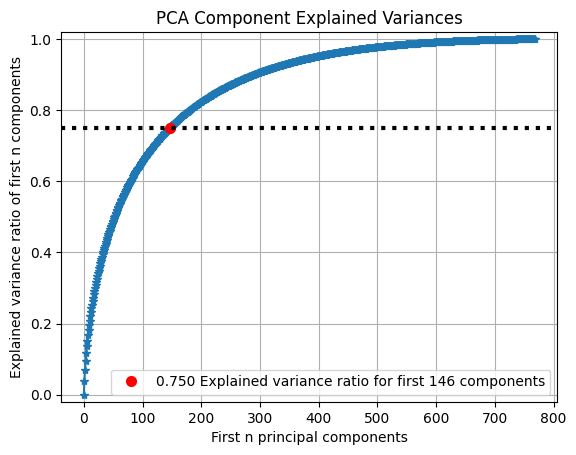

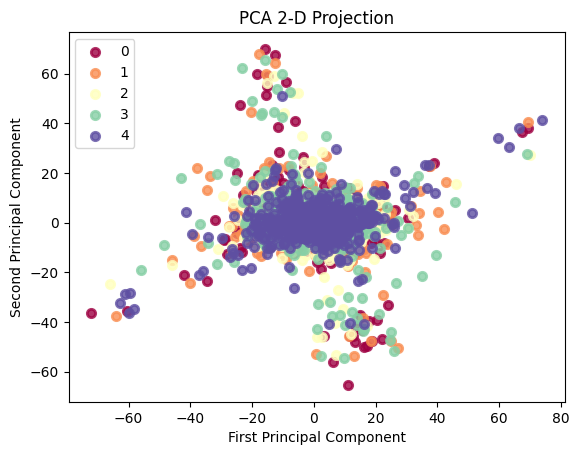

In [38]:
decompose_spline_trajectories(trajectories, num_samples, first_string_length, data=None)

In [46]:
#do PCA on the least squares linear mapping between activations at two layers

def decompose_linear_mapping(activations, layer1, layer2):
    num_labels = activations.shape[0]
    X = activations[:, :50, layer1, 1:, :]
    X = X.reshape(-1, X.shape[2], X.shape[3])
    Y = activations[:, :50, layer2, 1:, :]
    Y = Y.reshape(-1, Y.shape[2], Y.shape[3])

    W = np.zeros((X.shape[0], X.shape[-1]**2))
    for sample in range(X.shape[0]):
        x = X[sample, :, :]
        y = Y[sample, :, :]
        w = np.linalg.lstsq(x, y, rcond=None)[0]
        W[sample, :] = w.flatten()

    pca = PCA()
    pca.fit(W)
    plot_pca_component_variance(pca)

    y = np.zeros(W.shape[0], dtype=int)
    samples_per_label = W.shape[0] // num_labels
    for label in range(num_labels):
        y[label*samples_per_label:(label+1)*samples_per_label] = label
    
    plot_pca_2d_projection(pca, W, y)

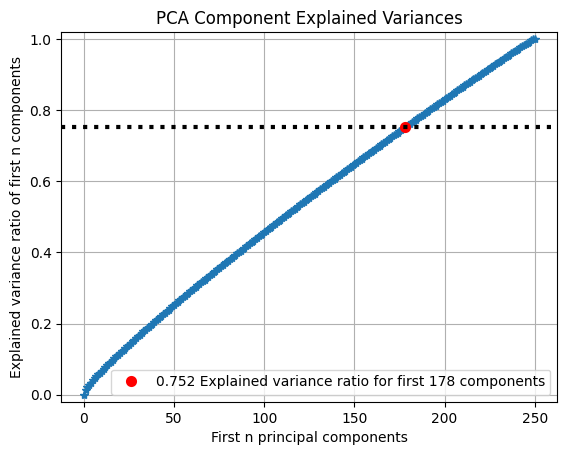

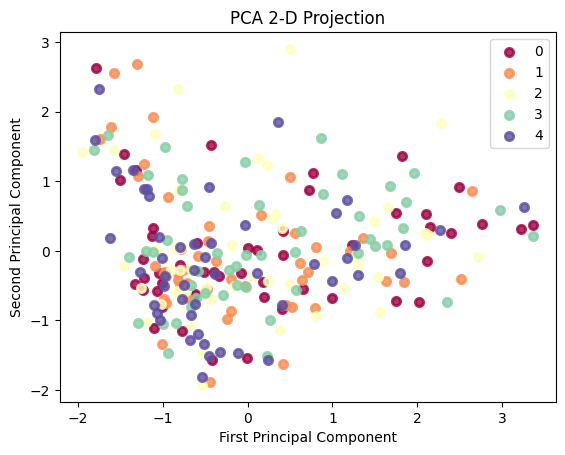

In [47]:
decompose_linear_mapping(activations, 7, 8)

# Checking that trajectories are being used

In [4]:
print(activations.shape)

(1, 5815, 13, 10, 768)


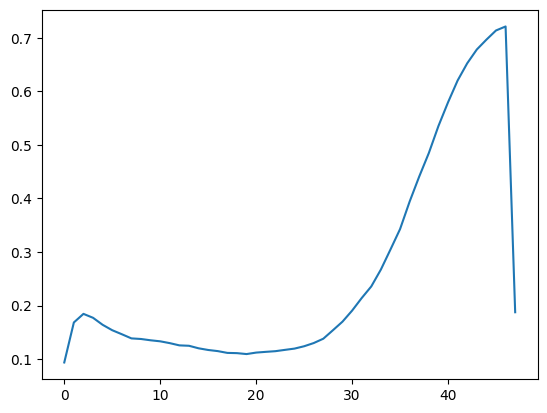

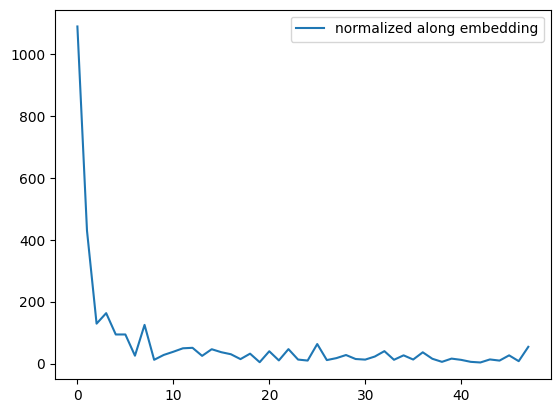

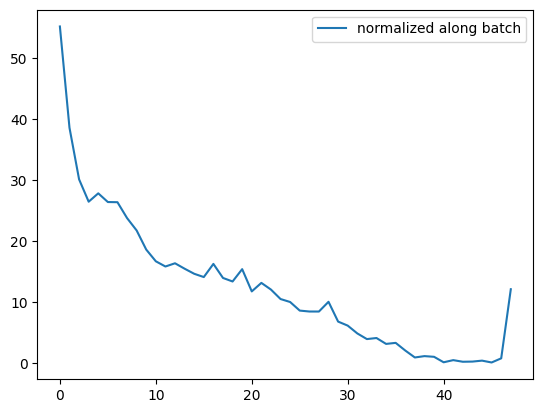

In [11]:
# for every layer, learn a linear transformation that maps the activations to the next layer's activations
# if the representation at one layer can be linearly transformed to the next layer, then the representation should be straighter

def calculate_kl(x, y, axis):
    tensor1 = x / x.sum(axis=axis, keepdims=True)
    tensor2 = y / y.sum(axis=axis, keepdims=True)
    #remove zeros
    tensor1 = np.clip(tensor1, 1e-12, 1)
    tensor2 = np.clip(tensor2, 1e-12, 1)
    kl_divergence = np.sum(tensor1 * (np.log(tensor1) - np.log(tensor2)), axis=axis)
    return kl_divergence

def learn_linear_transformations(activations):
    num_layers = activations.shape[2]

    num_samples = 100

    accuracies = []
    r2 = []
    divergences_normalized_along_embd = []
    divergences_normalized_along_batch = []

    for layer in range(num_layers-1):

        # W matrix for each token -------

        X = activations[:, :num_samples, layer, 1:, :]
        X = X.reshape(-1, X.shape[2], X.shape[3])
        Y = activations[:, :num_samples, layer+1, 1:, :]
        Y = Y.reshape(-1, Y.shape[2], Y.shape[3])

        layer_accuracies = []
        layer_r2 = []
        ldnae = []
        ldnab = []

        for token_num in range(3, X.shape[1]):
            split = int(X.shape[0] * 0.8)
            x_train = X[:split, token_num, :]
            y_train = Y[:split, token_num, :]
            x_test = X[split:, token_num, :]
            y_test = Y[split:, token_num, :]
            w = np.linalg.lstsq(x_train, y_train, rcond=None)[0]
            Y_pred = np.dot(x_test, w)
            layer_accuracies.append(np.mean((y_test - Y_pred)**2))

            #calculate r^2
            y_mean = np.mean(y_test, axis=0)
            total_sum_of_squares = np.sum((y_test - y_mean)**2)
            residual_sum_of_squares = np.sum((y_test - Y_pred)**2)
            layer_r2.append(1 - residual_sum_of_squares / total_sum_of_squares)

            x = X[:, token_num, :]
            y = Y[:, token_num, :]
            ldnae.append(calculate_kl(x, y, axis=1))
            ldnab.append(calculate_kl(x, y, axis=0))
        
        accuracies.append(np.mean(layer_accuracies))
        r2.append(np.mean(layer_r2))
        divergences_normalized_along_embd.append(np.mean(ldnae))
        divergences_normalized_along_batch.append(np.mean(ldnab))


    return accuracies, r2, divergences_normalized_along_embd, divergences_normalized_along_batch

accuracies, r2, divergences_normalized_along_embd, divergences_normalized_along_batch = learn_linear_transformations(activations)

# plt.plot(accuracies)
# plt.show()

plt.plot(r2)
plt.show()

#this is the KL divergence for each sample (comparing sample at layer i to sample at layer i+1)
plt.plot(divergences_normalized_along_embd, label="normalized along embedding")
plt.legend()
plt.show()

#this is the KL divergence for each dimension of the embedding (comparing dim at layer i to dim at layer i+1 over samples)
plt.plot(divergences_normalized_along_batch, label="normalized along batch")
plt.legend()
plt.show()

In [21]:
divergences_normalized_along_batch

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

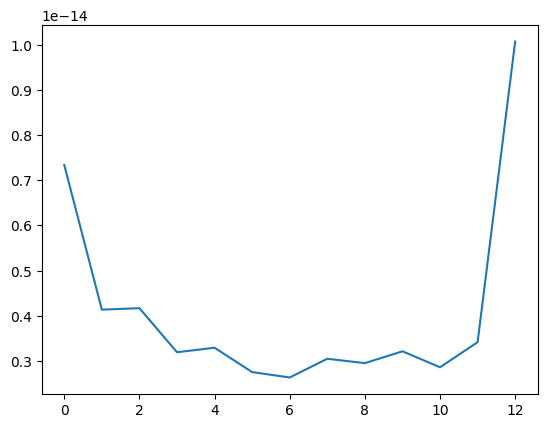

In [13]:
#same thing as above, but each layer predicts the final representation

# for every layer, learn a linear transformation that maps the activations to the next layer's activations
# if the representation at one layer can be linearly transformed to the next layer, then the representation should be straighter

def learn_linear_transformations(activations):
    num_labels = activations.shape[0]
    num_layers = activations.shape[2]
    num_samples = activations.shape[1]

    accuracies = []

    Y = activations[:, 100:110, -1, 1:, :]
    Y = Y.reshape(-1, Y.shape[2], Y.shape[3])

    for layer in range(num_layers):

        # W matrix for each sample -------
        
        X = activations[:, 100:110, layer, 1:, :]
        X = X.reshape(-1, X.shape[2], X.shape[3])
        
        layer_accuracies = []
        for sample in range(X.shape[0]):
            x = X[sample, :, :]
            y = Y[sample, :, :]
            w = np.linalg.lstsq(x, y, rcond=None)[0]
            #set w to be the identity matrix
            # w = np.eye(x.shape[1])
            Y_pred = np.dot(x, w)
            layer_accuracies.append(np.mean(np.abs(y - Y_pred)))
        
        accuracies.append(np.mean(layer_accuracies))
        
    return accuracies

accuracies = learn_linear_transformations(activations)
plt.plot(accuracies)

# Clustering and then doing mean field theoretic manifold analysis

In [18]:
from mftma.manifold_analysis_correlation import manifold_analysis_corr
from sklearn.cluster import KMeans

def cluster_activations(X, num_labels):
    kmeans = KMeans(n_clusters=num_labels)
    kmeans.fit(X)
    y = kmeans.predict(X)
    return y

def MFTMA(activations, layer):
    num_labels = activations.shape[0]
    X = activations[:, :100, layer, :, :].reshape(-1, activations.shape[-1])
    pca = PCA(n_components=10)
    pca.fit(X)
    reduced_activations = pca.transform(X)
    clusters = cluster_activations(reduced_activations, num_labels)

    clustered_X = []
    for label in range(num_labels):
        cluster_matrix = X[clusters == label].T[:, :100]
        print(cluster_matrix.shape)
        clustered_X.append(cluster_matrix)
    
    clustered_X = np.array(clustered_X)

    kappa = 0
    n_t = 200

    capacity_all, radius_all, dimension_all, center_correlation, K = manifold_analysis_corr(X, kappa, n_t)

    

In [19]:
MFTMA(activations, 9)

/om2/user/jackking/anaconda/envs/modular_transformers/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(768, 100)
(768, 100)
(768, 100)
(768, 100)
(768, 100)


AxisError: axis 1 is out of bounds for array of dimension 1

In [1]:
import numpy as np
from mftma.manifold_analysis_correlation import manifold_analysis_corr

np.random.seed(0)
X = [np.random.randn(1000, 50) for i in range(100)] 
kappa = 0
n_t = 200

capacity_all, radius_all, dimension_all, center_correlation, K = manifold_analysis_corr(X, kappa, n_t)

AttributeError: 'NoneType' object has no attribute 'is_available'